Code is based on https://github.com/jhuggins/viabel

In [1]:
import pickle
import pystan
import autograd.numpy as np

from viabel.objectives import (black_box_klvi,
                               black_box_chivi)

from viabel.family import (mean_field_gaussian_variational_family,
                           mean_field_t_variational_family,
                           t_variational_family)

from viabel.models import make_stan_log_density
from viabel.optimization import adagrad_optimize
from experiments import (plot_dist_to_opt_param,
                         check_approx_accuracy,
                         psis_correction)

import pandas as pd

import time
from scipy.stats import norm
from scipy.stats import gamma
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Define the model

In [2]:
test_model = """data {
  int<lower=0> N;   // number of observations
  int <lower=0> D;  // number of predictors
  matrix[N, D] x;   // predictor matrix
  vector[N] y;      // outcome vector
}

parameters {
  vector[D] beta;        // coefficients for predictors
  real <lower=0> sigma;  // variance
}

model {
   beta ~ normal(0,1);
   sigma ~ gamma(0.5,0.5);
   y ~ normal(x * beta, sigma);
}"""

Generate of open existing a pkl file of the model

In [3]:
compiled_model_file = 'blr_reg_model.pkl'

try:
    with open(compiled_model_file, 'rb') as f:
        regression_model = pickle.load(f)
except:
    regression_model = pystan.StanModel(model_code=test_model,
                                        model_name='regression_model')
    with open('blr_reg_model.pkl', 'wb') as f:
        pickle.dump(regression_model, f)

Get data

In [4]:
# SYNTHETIC
# np.random.seed(1234)

# N = 1000
# D = 10
# beta_gen = np.random.randn(D, 1)
# sigma_gen = np.random.gamma(1, 1, 1)

# x = np.random.randn(N, D)
# y_raw = x.dot(beta_gen) + np.random.randn(N, 1)*np.sqrt(sigma_gen)
# y = y_raw - np.mean(y_raw)
# # convert from Nx1 matrix to Nx1 vector
# y = y.flatten()

In [5]:
#print(beta_gen)

In [6]:
#print(sigma_gen)

Import the dataset

In [7]:
data = pd.read_csv("bodyfat.csv").drop("Density", axis=1)
data = data - data.mean()
data.head(3)

,Bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,-6.850794,-21.884921,-24.674405,-2.39881,-1.792063,-7.724206,-7.355952,-5.404762,-0.405952,-1.290476,-1.202381,-0.273413,-1.263889,-1.129762
1,-13.050794,-22.884921,-5.674405,2.10119,0.507937,-7.224206,-9.555952,-1.204762,-0.705952,-1.290476,0.297619,-1.773413,0.236111,-0.029762
2,6.149206,-22.884921,-24.924405,-3.89881,-3.992063,-5.024206,-4.655952,-0.704762,0.194048,0.309524,0.897619,-3.473413,-3.463889,-1.629762


In [8]:
y = data["Bodyfat"].values
# centre the response to adjust for no intercept
y = y - np.mean(y)

x = data.drop("Bodyfat", axis=1)

N = x.shape[0]
D = x.shape[1]

First, generate ground-truth posterior samples using Stan's dynamic HMC implementation:

In [9]:
data = dict(N=N, D=D, x=x, y=y)
fit = regression_model.sampling(data=data, iter=50000, thin=50, chains=10)

In [10]:
true_beta_mean = np.mean(fit['beta'], axis=0)
true_beta_cov = np.cov(fit['beta'].T)
print('true beta mean =', true_beta_mean)
print('true beta cov =', true_beta_cov)

true beta mean = [ 0.05459832 -0.09528642 -0.07644066 -0.48363749 -0.01824114  0.95663095
 -0.2000818   0.23570235  0.00990782  0.13346214  0.1787938   0.40898731
 -1.27938096]
true beta cov = [[ 9.97200337e-04  3.45621380e-04  3.68728016e-04 -7.78539413e-04
  -1.10697829e-04 -1.16318692e-03  2.21506005e-04  1.76549994e-03
  -1.96880775e-03  5.20538406e-04 -4.35301435e-04  7.91531586e-04
  -4.01240462e-03]
 [ 3.45621380e-04  2.84756057e-03 -2.41060764e-03 -3.77845948e-03
  -2.18422092e-03 -9.52696853e-04 -4.13429772e-03 -5.67353506e-04
  -2.80330350e-03 -2.53522149e-03 -1.54456099e-03 -1.39916280e-04
  -3.09299142e-03]
 [ 3.68728016e-04 -2.41060764e-03  9.23920817e-03  3.17649442e-04
   2.09330990e-03  1.04308374e-03  3.58892541e-03  2.63097431e-03
  -1.89339286e-03  1.43998504e-03  1.17676525e-03  2.32454254e-04
  -3.98792551e-03]
 [-7.78539413e-04 -3.77845948e-03  3.17649442e-04  5.15356691e-02
  -5.97618387e-04 -1.75824473e-04  5.76037988e-03 -3.19351687e-03
   8.24154695e-03  4.514

In [11]:
true_sigma_mean = np.mean(fit['sigma'], axis=0)
true_sigma_cov = np.cov(fit['sigma'].T)
print('true sigma mean =', true_sigma_mean)
print('true sigma cov =', true_sigma_cov)

true sigma mean = 4.293666876803905
true sigma cov = 0.037078159507807996


In [12]:
vec1 = fit['beta']
vec2 = np.array(fit['sigma'])
vec = []
for i in range(len(vec1)):
    temp = list(np.append(vec1[i], vec2[i]))
    vec.append(temp)
vec = np.array(vec)

In [13]:
true_mean = np.mean(vec, axis=0)
true_cov = np.cov(vec.T)

In [14]:
print('true mean =', true_mean)
print('true cov =', true_cov)

true mean = [ 0.05459832 -0.09528642 -0.07644066 -0.48363749 -0.01824114  0.95663095
 -0.2000818   0.23570235  0.00990782  0.13346214  0.1787938   0.40898731
 -1.27938096  4.29366688]
true cov = [[ 9.97200337e-04  3.45621380e-04  3.68728016e-04 -7.78539413e-04
  -1.10697829e-04 -1.16318692e-03  2.21506005e-04  1.76549994e-03
  -1.96880775e-03  5.20538406e-04 -4.35301435e-04  7.91531586e-04
  -4.01240462e-03 -8.65895956e-05]
 [ 3.45621380e-04  2.84756057e-03 -2.41060764e-03 -3.77845948e-03
  -2.18422092e-03 -9.52696853e-04 -4.13429772e-03 -5.67353506e-04
  -2.80330350e-03 -2.53522149e-03 -1.54456099e-03 -1.39916280e-04
  -3.09299142e-03 -7.31295650e-05]
 [ 3.68728016e-04 -2.41060764e-03  9.23920817e-03  3.17649442e-04
   2.09330990e-03  1.04308374e-03  3.58892541e-03  2.63097431e-03
  -1.89339286e-03  1.43998504e-03  1.17676525e-03  2.32454254e-04
  -3.98792551e-03 -3.00063038e-05]
 [-7.78539413e-04 -3.77845948e-03  3.17649442e-04  5.15356691e-02
  -5.97618387e-04 -1.75824473e-04  5.760

In [15]:
fit

Inference for Stan model: regression_model_b1ab85b6e8abedc0878d3fa66ea1be75.
10 chains, each with iter=50000; warmup=25000; thin=50; 
post-warmup draws per chain=500, total post-warmup draws=5000.

           mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]    0.05  4.5e-4   0.03 -7.6e-3   0.03   0.05   0.08   0.12   5019    1.0
beta[2]    -0.1  7.5e-4   0.05    -0.2  -0.13   -0.1  -0.06 8.4e-3   5087    1.0
beta[3]   -0.08  1.4e-3    0.1   -0.26  -0.14  -0.08  -0.01   0.11   5052    1.0
beta[4]   -0.48  3.2e-3   0.23   -0.93  -0.64  -0.48  -0.33  -0.04   4894    1.0
beta[5]   -0.02  1.4e-3    0.1   -0.22  -0.09  -0.02   0.05   0.18   4907    1.0
beta[6]    0.96  1.2e-3   0.09    0.79    0.9   0.96   1.01   1.12   4951    1.0
beta[7]    -0.2  2.0e-3   0.14   -0.49   -0.3   -0.2   -0.1   0.08   4913    1.0
beta[8]    0.24  2.1e-3   0.14   -0.04   0.14   0.23   0.33   0.52   4918    1.0
beta[9]  9.9e-3  3.3e-3   0.24   -0.46  -0.15 9.5e-3   0.17   0.48   5019

# KLVI

## Mean field with Gaussian

In [16]:
# def logjointpdf(samples, x=x, y=y, D=D):
#     beta, log_sigma = samples[:, 0:D], samples[:, D]
#     mu = np.dot(x, np.transpose(beta))
    
#     lpdf = np.zeros(len(samples))

#     print("I'm here")
#     print(norm.logpdf(0,1,np.exp(log_sigma[0])))
#     for i in range(len(samples)):
#         p1 = sum(norm.logpdf(y, mu[:,i], np.exp(log_sigma[i])))
#         p2 = gamma.logpdf(np.exp(log_sigma[i]), .5, loc=0, scale=.5)
#         p3 = sum(norm.logpdf(beta[i,:], 0, 1))
                 
#         lpdf[i] = p1 + p2 + p3
     
#     return lpdf

In [17]:
mf_gaussian_var_family = mean_field_gaussian_variational_family(D+1)

init_mean = np.zeros(D+1)
init_log_std = np.ones(D+1)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 2000

In [18]:
stan_log_density = make_stan_log_density(fit)

In [19]:
klvi_objective_and_grad = black_box_klvi(mf_gaussian_var_family, stan_log_density, 100)

klvi_var_param, klvi_param_history, klvi_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=1e-2)

Average Loss = 588.28: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.30it/s]


In [20]:
#plot_dist_to_opt_param(klvi_param_history, klvi_var_param)

In [21]:
check_approx_accuracy(mf_gaussian_var_family, klvi_var_param, true_mean, true_cov, verbose=True);

mean   = [ 5.44384297e-02 -1.02126322e-01 -7.30403373e-02 -4.85712732e-01
 -3.41180830e-04  9.40875347e-01 -1.69420817e-01  2.37305100e-01
  2.21088054e-03  1.18992872e-01  1.69170660e-01  3.99143009e-01
 -1.17513989e+00  1.50436742e+00]
stdevs = [0.03112333 0.02675642 0.07930115 0.13354185 0.05161203 0.04486748
 0.05941958 0.07102985 0.13597238 0.17690945 0.11087364 0.15093563
 0.30545673 0.04822361]

mean error             = 2.79
stdev error            = 0.295
||cov error||_2^{1/2}  = 0.365
||true cov||_2^{1/2}   = 0.47


In [22]:
mc_samples = 100000

samples, smoothed log weights, khat

In [23]:
klvi_samples, klvi_slw, klvi_khat = psis_correction(stan_log_density, mf_gaussian_var_family, klvi_var_param, mc_samples)

In [24]:
print(klvi_khat)

0.9336263340218836


In [25]:
klvi_slw

array([-22.14364824, -42.29143453, -22.04874729, ..., -22.11146712,
       -23.7798717 , -23.32283541])

### VSBC diagnostics

In [26]:
#     def logjointpdf(samples, x=xtemp, y=y, D=D):
#         beta, log_sigma = samples[:, 0:D], samples[:, D]
#         mu = np.dot(x, np.transpose(beta))

#         lpdf = np.zeros(len(samples))
#         for i in range(len(samples)):
#             p1 = sum(norm.logpdf(y, mu[:,i], np.exp(log_sigma[i])))
#             p2 = gamma.logpdf(np.exp(log_sigma[i]), .5, 0, .5)
#             p3 = sum(norm.logpdf(beta[i,:], 0, 1))

#             lpdf[i] = p1 + p2 + p3

#         return lpdf
    
    # initialise klvi
#     def logjointpdf(x, data=xtemp, y=ytemp, D=D):
#         beta, log_sigma = x[:, 0:D], x[:, D]
#         mu = np.dot(x.values, np.transpose(beta))
        
#         obs_density = norm.logpdf(y, mu, np.exp(log_sigma))
#         sigma_density = gamma.logpdf(np.exp(log_sigma), .5, 0, .5)
#         beta_density = norm.logpdf(beta, 0, 1)
        
#         return sum(obs_density)+sum(beta_density)+sigma_density

In [27]:
M = 100
klvi_probs = np.zeros(shape=(D+1, M))

In [28]:
start = time.time()
for i in range(M):
    start_loop = time.time()
    
    # sample from prior
    btemp = np.random.randn(1, D)
    mtemp = np.dot(x.values, np.transpose(btemp))
    stemp = np.random.gamma(.5, .5, 1)
    ytemp = mtemp + stemp
    
    datatemp = dict(N=N, D=D, x=x, y=y)
    fittemp = regression_model.sampling(data=datatemp, iter=20000, thin=20, chains=10)
    stan_log_density_temp = make_stan_log_density(fittemp)
    
    klvi_objective_and_grad_temp = black_box_klvi(mf_gaussian_var_family, stan_log_density_temp, 100)
    
    # run klvi
    klvi_temp_var_param, _, _, _ = \
        adagrad_optimize(n_iters, klvi_objective_and_grad_temp, init_var_param, learning_rate=.01)
    
    # extract beta mean and std
    b_mean_temp = klvi_temp_var_param[:D]
    b_std_temp = np.exp(klvi_temp_var_param[D+1:][0:D])
    
    # generate 1000 sample from the variational family
    nn = 1000
    sample_temp = mf_gaussian_var_family.sample(klvi_temp_var_param, nn)
    
    # compute log sigma of the samples
    logs_sample_temp = []
    for j in range(nn):
        logs_sample_temp.append(sample_temp[j][-1])
    logs_sample_temp = np.array(logs_sample_temp)
    logs_sample_temp = np.log(logs_sample_temp)
    
    # get the cdf values
    klvi_probs[0:D, i] = norm.cdf(btemp, b_mean_temp[0:D], b_std_temp[0:D])
    klvi_probs[D, i] = norm.cdf(np.log(stemp), np.mean(logs_sample_temp), np.std(logs_sample_temp))
    
    end_loop = time.time()
    print("Iteration = %i, loop time = %f, time elapsed = %f" % (i, end_loop-start_loop, end_loop-start))
    
end = time.time()
print("Total time taken: %f" % (end-start))

Average Loss = 608.13: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 240.63it/s]


Iteration = 0, loop time = 23.268147, time elapsed = 23.268147


Average Loss = 592.63: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.89it/s]


Iteration = 1, loop time = 23.295170, time elapsed = 46.564317


Average Loss = 597.68: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.99it/s]


Iteration = 2, loop time = 23.558640, time elapsed = 70.123958


Average Loss = 603.51: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 239.30it/s]


Iteration = 3, loop time = 24.589740, time elapsed = 94.714699


Average Loss = 598.87: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 240.92it/s]


Iteration = 4, loop time = 23.960915, time elapsed = 118.675614


Average Loss = 598.4: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.70it/s]


Iteration = 5, loop time = 22.900501, time elapsed = 141.577115


Average Loss = 590.2: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 216.32it/s]


Iteration = 6, loop time = 24.918723, time elapsed = 166.496840


Average Loss = 598.5: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.63it/s]


Iteration = 7, loop time = 24.003871, time elapsed = 190.501712


Average Loss = 592.07: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.08it/s]


Iteration = 8, loop time = 23.833673, time elapsed = 214.336386


Average Loss = 595.2: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 239.20it/s]


Iteration = 9, loop time = 23.072252, time elapsed = 237.409641


Average Loss = 614.45: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 237.31it/s]


Iteration = 10, loop time = 23.790900, time elapsed = 261.201541


Average Loss = 590.88: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 239.76it/s]


Iteration = 11, loop time = 22.555061, time elapsed = 283.756603


Average Loss = 582.91: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 239.27it/s]


Iteration = 12, loop time = 23.126851, time elapsed = 306.883454


Average Loss = 604.69: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.64it/s]


Iteration = 13, loop time = 23.326195, time elapsed = 330.210650


Average Loss = 600.43: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 239.16it/s]


Iteration = 14, loop time = 23.234122, time elapsed = 353.445773


Average Loss = 611.54: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.70it/s]


Iteration = 15, loop time = 23.158346, time elapsed = 376.605120


Average Loss = 600.72: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 240.05it/s]


Iteration = 16, loop time = 23.114758, time elapsed = 399.720879


Average Loss = 592.69: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 239.05it/s]


Iteration = 17, loop time = 22.794383, time elapsed = 422.516262


Average Loss = 602.87: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.50it/s]


Iteration = 18, loop time = 23.924386, time elapsed = 446.441649


Average Loss = 591.3: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 239.33it/s]


Iteration = 19, loop time = 23.138969, time elapsed = 469.580618


Average Loss = 614.4: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.22it/s]


Iteration = 20, loop time = 23.466583, time elapsed = 493.048203


Average Loss = 592.3: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.98it/s]


Iteration = 21, loop time = 22.628200, time elapsed = 515.677403


Average Loss = 601.18: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 239.02it/s]


Iteration = 22, loop time = 23.910341, time elapsed = 539.588745


Average Loss = 595.54: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.22it/s]


Iteration = 23, loop time = 23.847983, time elapsed = 563.437727


Average Loss = 612.13: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.34it/s]


Iteration = 24, loop time = 24.192782, time elapsed = 587.631510


Average Loss = 595.42: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 220.87it/s]


Iteration = 25, loop time = 26.852096, time elapsed = 614.484607


Average Loss = 586.47: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 228.65it/s]


Iteration = 26, loop time = 26.380607, time elapsed = 640.866215


Average Loss = 593.96: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 237.03it/s]


Iteration = 27, loop time = 25.499665, time elapsed = 666.365880


Average Loss = 596.85: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 240.02it/s]


Iteration = 28, loop time = 24.253857, time elapsed = 690.620739


Average Loss = 596.55: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.01it/s]


Iteration = 29, loop time = 23.733391, time elapsed = 714.354129


Average Loss = 584.41: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.10it/s]


Iteration = 30, loop time = 25.192459, time elapsed = 739.548591


Average Loss = 595.83: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 239.58it/s]


Iteration = 31, loop time = 24.131764, time elapsed = 763.680355


Average Loss = 610.18: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 240.31it/s]


Iteration = 32, loop time = 23.202088, time elapsed = 786.883443


Average Loss = 598.33: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.86it/s]


Iteration = 33, loop time = 23.456155, time elapsed = 810.340598


Average Loss = 593.4: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.07it/s]


Iteration = 34, loop time = 24.172824, time elapsed = 834.514424


Average Loss = 597.32: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.62it/s]


Iteration = 35, loop time = 23.755465, time elapsed = 858.270890


Average Loss = 605.85: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.02it/s]


Iteration = 36, loop time = 23.913745, time elapsed = 882.185639


Average Loss = 589.2: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 210.18it/s]


Iteration = 37, loop time = 24.267790, time elapsed = 906.454430


Average Loss = 598.61: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.52it/s]


Iteration = 38, loop time = 23.709388, time elapsed = 930.164820


Average Loss = 601.25: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 237.16it/s]


Iteration = 39, loop time = 23.826013, time elapsed = 953.991833


Average Loss = 615.71: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 237.94it/s]


Iteration = 40, loop time = 23.724542, time elapsed = 977.717376


Average Loss = 594.1: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.58it/s]


Iteration = 41, loop time = 23.596094, time elapsed = 1001.314471


Average Loss = 611.63: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 219.09it/s]


Iteration = 42, loop time = 23.981267, time elapsed = 1025.296739


Average Loss = 583.52: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 241.15it/s]


Iteration = 43, loop time = 23.054965, time elapsed = 1048.352705


Average Loss = 596.92: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.67it/s]


Iteration = 44, loop time = 24.110757, time elapsed = 1072.464463


Average Loss = 593.44: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 240.50it/s]


Iteration = 45, loop time = 24.180645, time elapsed = 1096.646108


Average Loss = 601.64: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.37it/s]


Iteration = 46, loop time = 23.151806, time elapsed = 1119.798915


Average Loss = 598.41: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 239.16it/s]


Iteration = 47, loop time = 23.113412, time elapsed = 1142.913329


Average Loss = 594.67: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.50it/s]


Iteration = 48, loop time = 23.539689, time elapsed = 1166.454019


Average Loss = 594.22: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.94it/s]


Iteration = 49, loop time = 24.312713, time elapsed = 1190.767734


Average Loss = 604.79: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 237.61it/s]


Iteration = 50, loop time = 23.266539, time elapsed = 1214.035274


Average Loss = 597.83: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.84it/s]


Iteration = 51, loop time = 24.320373, time elapsed = 1238.356647


Average Loss = 597.49: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 237.08it/s]


Iteration = 52, loop time = 24.236595, time elapsed = 1262.594244


Average Loss = 600.76: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 221.11it/s]


Iteration = 53, loop time = 24.821771, time elapsed = 1287.417015


Average Loss = 590.73: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 240.46it/s]


Iteration = 54, loop time = 23.975018, time elapsed = 1311.393033


Average Loss = 592.96: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 237.07it/s]


Iteration = 55, loop time = 23.796402, time elapsed = 1335.190436


Average Loss = 596.07: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 242.09it/s]


Iteration = 56, loop time = 23.578446, time elapsed = 1358.769882


Average Loss = 594.69: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 241.34it/s]


Iteration = 57, loop time = 23.858215, time elapsed = 1382.629098


Average Loss = 598.93: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 242.39it/s]


Iteration = 58, loop time = 22.780378, time elapsed = 1405.410477


Average Loss = 588.7: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.88it/s]


Iteration = 59, loop time = 23.893321, time elapsed = 1429.304800


Average Loss = 598.79: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 216.36it/s]


Iteration = 60, loop time = 24.589007, time elapsed = 1453.894807


Average Loss = 595.64: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.60it/s]


Iteration = 61, loop time = 24.438419, time elapsed = 1478.334227


Average Loss = 592.8: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.41it/s]


Iteration = 62, loop time = 25.092806, time elapsed = 1503.428034


Average Loss = 589.92: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.76it/s]


Iteration = 63, loop time = 24.823351, time elapsed = 1528.252387


Average Loss = 594.48: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.67it/s]


Iteration = 64, loop time = 25.397907, time elapsed = 1553.650294


Average Loss = 595.45: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.67it/s]


Iteration = 65, loop time = 23.535929, time elapsed = 1577.186223


Average Loss = 596.77: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 237.33it/s]


Iteration = 66, loop time = 23.135696, time elapsed = 1600.322919


Average Loss = 596.73: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.21it/s]


Iteration = 67, loop time = 23.989312, time elapsed = 1624.313218


Average Loss = 593.97: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 217.87it/s]


Iteration = 68, loop time = 24.453853, time elapsed = 1648.768072


Average Loss = 594.8: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 239.13it/s]


Iteration = 69, loop time = 23.525918, time elapsed = 1672.294990


Average Loss = 596.27: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 237.48it/s]


Iteration = 70, loop time = 23.786667, time elapsed = 1696.081657


Average Loss = 589.83: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.90it/s]


Iteration = 71, loop time = 23.667655, time elapsed = 1719.751317


Average Loss = 592.26: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 239.02it/s]


Iteration = 72, loop time = 23.325209, time elapsed = 1743.077514


Average Loss = 604.27: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.50it/s]


Iteration = 73, loop time = 24.521297, time elapsed = 1767.599813


Average Loss = 593.36: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.39it/s]


Iteration = 74, loop time = 25.677627, time elapsed = 1793.278441


Average Loss = 599.66: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.92it/s]


Iteration = 75, loop time = 25.154874, time elapsed = 1818.434316


Average Loss = 589.96: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.93it/s]


Iteration = 76, loop time = 25.153224, time elapsed = 1843.588541


Average Loss = 619.12: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 218.55it/s]


Iteration = 77, loop time = 25.525987, time elapsed = 1869.115528


Average Loss = 596.66: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 230.30it/s]


Iteration = 78, loop time = 24.452109, time elapsed = 1893.568638


Average Loss = 598.95: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 239.36it/s]


Iteration = 79, loop time = 23.253890, time elapsed = 1916.823529


Average Loss = 600.51: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.15it/s]


Iteration = 80, loop time = 24.158689, time elapsed = 1940.982218


Average Loss = 600.54: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 237.85it/s]


Iteration = 81, loop time = 23.498357, time elapsed = 1964.481577


Average Loss = 594: 100%|█████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.59it/s]


Iteration = 82, loop time = 24.341232, time elapsed = 1988.823810


Average Loss = 590.43: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.06it/s]


Iteration = 83, loop time = 24.467416, time elapsed = 2013.292228


Average Loss = 594.82: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.69it/s]


Iteration = 84, loop time = 23.162758, time elapsed = 2036.455986


Average Loss = 596.81: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.28it/s]


Iteration = 85, loop time = 24.267068, time elapsed = 2060.724054


Average Loss = 590.91: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.14it/s]


Iteration = 86, loop time = 24.848224, time elapsed = 2085.573278


Average Loss = 621.72: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.61it/s]


Iteration = 87, loop time = 23.708672, time elapsed = 2109.282946


Average Loss = 598.73: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.91it/s]


Iteration = 88, loop time = 23.930122, time elapsed = 2133.214070


Average Loss = 592.23: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.27it/s]


Iteration = 89, loop time = 24.430039, time elapsed = 2157.645110


Average Loss = 587.76: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.62it/s]


Iteration = 90, loop time = 24.313668, time elapsed = 2181.959777


Average Loss = 592.61: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 218.57it/s]


Iteration = 91, loop time = 24.356999, time elapsed = 2206.317777


Average Loss = 598.14: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 234.20it/s]


Iteration = 92, loop time = 23.709445, time elapsed = 2230.027222


Average Loss = 589.11: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.62it/s]


Iteration = 93, loop time = 24.033139, time elapsed = 2254.061363


Average Loss = 596.37: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 237.45it/s]


Iteration = 94, loop time = 24.944175, time elapsed = 2279.006538


Average Loss = 591.85: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 209.71it/s]


Iteration = 95, loop time = 26.546484, time elapsed = 2305.554023


Average Loss = 598.57: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.41it/s]


Iteration = 96, loop time = 23.701294, time elapsed = 2329.256318


Average Loss = 597.44: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.48it/s]


Iteration = 97, loop time = 23.914192, time elapsed = 2353.171510


Average Loss = 604.81: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.36it/s]


Iteration = 98, loop time = 23.214414, time elapsed = 2376.386925


Average Loss = 604.39: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.43it/s]


Iteration = 99, loop time = 24.168989, time elapsed = 2400.556902
Total time taken: 2400.557902


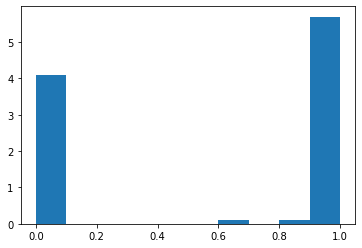

In [29]:
plt.hist(klvi_probs[1,:], bins=10, density=True, range=(0,1))
plt.show()

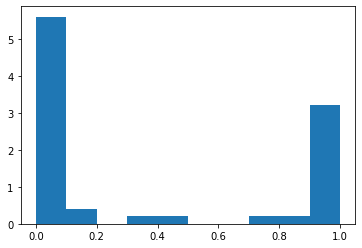

In [30]:
plt.hist(klvi_probs[10,:], bins=10, density=True, range=(0,1))
plt.show()

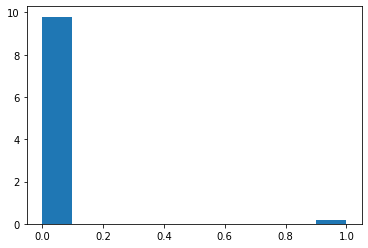

In [31]:
plt.hist(klvi_probs[D,:], bins=10, density=True, range=(0,1))
plt.show()

In [32]:
np.savetxt("klvi_probs.csv", klvi_probs, delimiter=",")

## CHIVI Mean field with Gaussian

In [33]:
mf_gaussian_var_family = mean_field_gaussian_variational_family(D+1)
chivi_objective_and_grad = black_box_chivi(2, mf_gaussian_var_family, stan_log_density, 200)

init_var_param = klvi_var_param.copy()
chivi_var_param, chivi_param_history, chivi_history, _ = \
    adagrad_optimize(n_iters, chivi_objective_and_grad, init_var_param, learning_rate=5e-4)

Average Loss = -511.49: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 76.96it/s]


In [34]:
#plot_dist_to_opt_param(chivi_param_history, chivi_var_param)

In [35]:
check_approx_accuracy(mf_gaussian_var_family, chivi_var_param, true_mean, true_cov, verbose=True);

mean   = [ 0.03044159 -0.11687745 -0.07357778 -0.49682534 -0.00692061  0.91256134
 -0.16779815  0.23072036 -0.0078093   0.11245042  0.16479693  0.38969709
 -1.17149286  1.66033655]
stdevs = [0.03120034 0.02639278 0.07908384 0.13149316 0.0508677  0.0441246
 0.05824157 0.06983455 0.13381767 0.17625355 0.10976294 0.14985301
 0.3013912  0.04522025]

mean error             = 2.64
stdev error            = 0.302
||cov error||_2^{1/2}  = 0.368
||true cov||_2^{1/2}   = 0.47


In [36]:
chivi_samples, chivi_slw, chivi_khat = psis_correction(stan_log_density, mf_gaussian_var_family, chivi_var_param, mc_samples)

In [37]:
print(chivi_khat)

1.6090683458626454


In [38]:
chivi_slw

array([-26.05411823, -22.38712062, -15.43665071, ..., -35.60389068,
       -40.10695417, -52.21119045])

### VSBC diagnostics

In [39]:
M = 100
chivi_probs = np.zeros(shape=(D+1, M))

In [40]:
start = time.time()
for i in range(M):
    start_loop = time.time()
    
    # sample from prior    
    btemp = np.random.randn(1, D)
    mtemp = np.dot(x.values, np.transpose(btemp))
    stemp = np.random.gamma(.5, .5, 1)
    ytemp = mtemp + stemp
    
    datatemp = dict(N=N, D=D, x=x, y=y)
    fittemp = regression_model.sampling(data=datatemp, iter=20000, thin=20, chains=10)
    stan_log_density_temp = make_stan_log_density(fittemp)
    
    chivi_objective_and_grad_temp = black_box_chivi(2, mf_gaussian_var_family, stan_log_density_temp, 200)
    
    init_var_param = klvi_temp_var_param.copy()
    # run chivi
    chivi_temp_var_param, _, _, _ = \
        adagrad_optimize(n_iters, chivi_objective_and_grad_temp, init_var_param, learning_rate=5e-4)
    
    # extract beta mean and std
    b_mean_temp = chivi_temp_var_param[:D]
    b_std_temp = np.exp(chivi_temp_var_param[D+1:][0:D])
    
    # generate 1000 sample from the variational family
    nn = 1000
    sample_temp = mf_gaussian_var_family.sample(chivi_temp_var_param, nn)
    
    # compute log sigma of the samples
    logs_sample_temp = []
    for j in range(nn):
        logs_sample_temp.append(sample_temp[j][-1])
    logs_sample_temp = np.array(logs_sample_temp)
    logs_sample_temp = np.log(logs_sample_temp)
    
    # get the cdf values
    chivi_probs[0:D, i] = norm.cdf(btemp, b_mean_temp[0:D], b_std_temp[0:D])
    chivi_probs[D, i] = norm.cdf(np.log(stemp), np.mean(logs_sample_temp), np.std(logs_sample_temp))
    
    end_loop = time.time()
    print("Iteration = %i, loop time = %f, time elapsed = %f" % (i, end_loop-start_loop, end_loop-start))
    
end = time.time()
print("Total time taken: %f" % (end-start))

Average Loss = -514.86: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.97it/s]


Iteration = 0, loop time = 42.288879, time elapsed = 42.288879


Average Loss = -513.17: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.22it/s]


Iteration = 1, loop time = 41.769654, time elapsed = 84.059534


Average Loss = -511.88: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.65it/s]


Iteration = 2, loop time = 40.414646, time elapsed = 124.476182


Average Loss = -513.44: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.66it/s]


Iteration = 3, loop time = 41.488414, time elapsed = 165.966598


Average Loss = -513.45: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.20it/s]


Iteration = 4, loop time = 41.642376, time elapsed = 207.609976


Average Loss = -516.37: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.29it/s]


Iteration = 5, loop time = 40.717673, time elapsed = 248.328650


Average Loss = -512.8: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.15it/s]


Iteration = 6, loop time = 40.998460, time elapsed = 289.328110


Average Loss = -512.39: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.07it/s]


Iteration = 7, loop time = 40.681664, time elapsed = 330.010775


Average Loss = -512.95: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 82.13it/s]


Iteration = 8, loop time = 41.395926, time elapsed = 371.407702


Average Loss = -516.2: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.42it/s]


Iteration = 9, loop time = 41.169204, time elapsed = 412.577908


Average Loss = -512.57: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.42it/s]


Iteration = 10, loop time = 40.855707, time elapsed = 453.434616


Average Loss = -514.02: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.36it/s]


Iteration = 11, loop time = 40.933700, time elapsed = 494.369317


Average Loss = -513.46: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 71.84it/s]


Iteration = 12, loop time = 42.650824, time elapsed = 537.021141


Average Loss = -512.12: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.23it/s]


Iteration = 13, loop time = 43.596812, time elapsed = 580.618954


Average Loss = -513.12: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.86it/s]


Iteration = 14, loop time = 43.178504, time elapsed = 623.798459


Average Loss = -512.49: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.70it/s]


Iteration = 15, loop time = 44.685513, time elapsed = 668.484973


Average Loss = -513.47: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 67.98it/s]


Iteration = 16, loop time = 45.809855, time elapsed = 714.295830


Average Loss = -513.03: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.54it/s]


Iteration = 17, loop time = 42.900492, time elapsed = 757.197324


Average Loss = -513.52: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 73.07it/s]


Iteration = 18, loop time = 43.622664, time elapsed = 800.820989


Average Loss = -518.68: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.28it/s]


Iteration = 19, loop time = 46.472282, time elapsed = 847.294242


Average Loss = -514.24: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 79.75it/s]


Iteration = 20, loop time = 44.214242, time elapsed = 891.509485


Average Loss = -512.49: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 77.69it/s]


Iteration = 21, loop time = 42.548860, time elapsed = 934.059345


Average Loss = -513.23: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 66.96it/s]


Iteration = 22, loop time = 45.887691, time elapsed = 979.948038


Average Loss = -513.05: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 71.29it/s]


Iteration = 23, loop time = 43.475232, time elapsed = 1023.424270


Average Loss = -514.39: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.32it/s]


Iteration = 24, loop time = 43.529880, time elapsed = 1066.955151


Average Loss = -513.25: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 70.79it/s]


Iteration = 25, loop time = 44.619909, time elapsed = 1111.576061


Average Loss = -512.31: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.01it/s]


Iteration = 26, loop time = 44.731283, time elapsed = 1156.308346


Average Loss = -512.92: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.09it/s]


Iteration = 27, loop time = 44.486031, time elapsed = 1200.795378


Average Loss = -513.07: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 73.24it/s]


Iteration = 28, loop time = 44.463481, time elapsed = 1245.259861


Average Loss = -512.66: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.36it/s]


Iteration = 29, loop time = 43.509902, time elapsed = 1288.771765


Average Loss = -513.04: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 67.44it/s]


Iteration = 30, loop time = 46.381626, time elapsed = 1335.154392


Average Loss = -513.51: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 76.19it/s]


Iteration = 31, loop time = 44.404876, time elapsed = 1379.560269


Average Loss = -512.18: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.08it/s]


Iteration = 32, loop time = 41.636800, time elapsed = 1421.198069


Average Loss = -512.65: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.26it/s]


Iteration = 33, loop time = 40.709074, time elapsed = 1461.908144


Average Loss = -513.09: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.11it/s]


Iteration = 34, loop time = 40.484515, time elapsed = 1502.393661


Average Loss = -513.18: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 75.66it/s]


Iteration = 35, loop time = 40.036447, time elapsed = 1542.431108


Average Loss = -513.16: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 71.86it/s]


Iteration = 36, loop time = 42.256694, time elapsed = 1584.688804


Average Loss = -513.55: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 70.97it/s]


Iteration = 37, loop time = 42.120231, time elapsed = 1626.810037


Average Loss = -512.65: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.09it/s]


Iteration = 38, loop time = 41.698728, time elapsed = 1668.509765


Average Loss = -513.06: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.67it/s]


Iteration = 39, loop time = 41.767565, time elapsed = 1710.278331


Average Loss = -513.22: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.36it/s]


Iteration = 40, loop time = 40.943231, time elapsed = 1751.222563


Average Loss = -515.27: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.54it/s]


Iteration = 41, loop time = 40.826464, time elapsed = 1792.050029


Average Loss = -512.95: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.21it/s]


Iteration = 42, loop time = 40.698354, time elapsed = 1832.749384


Average Loss = -517.22: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.99it/s]


Iteration = 43, loop time = 40.166675, time elapsed = 1872.917060


Average Loss = -511.95: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.13it/s]


Iteration = 44, loop time = 41.999479, time elapsed = 1914.918540


Average Loss = -513.22: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.42it/s]


Iteration = 45, loop time = 41.076641, time elapsed = 1955.997184


Average Loss = -513.45: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.55it/s]


Iteration = 46, loop time = 41.642867, time elapsed = 1997.642053


Average Loss = -512.41: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 66.97it/s]


Iteration = 47, loop time = 45.850091, time elapsed = 2043.493146


Average Loss = -514.95: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.46it/s]


Iteration = 48, loop time = 43.931441, time elapsed = 2087.425588


Average Loss = -513.56: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.82it/s]


Iteration = 49, loop time = 41.608640, time elapsed = 2129.035229


Average Loss = -512.45: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 71.07it/s]


Iteration = 50, loop time = 45.450078, time elapsed = 2174.486308


Average Loss = -513.68: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.51it/s]


Iteration = 51, loop time = 43.021330, time elapsed = 2217.507639


Average Loss = -513.66: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.02it/s]


Iteration = 52, loop time = 44.324360, time elapsed = 2261.833000


Average Loss = -512.66: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.18it/s]


Iteration = 53, loop time = 43.396914, time elapsed = 2305.230915


Average Loss = -513.63: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 75.09it/s]


Iteration = 54, loop time = 43.326049, time elapsed = 2348.557966


Average Loss = -512.91: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.48it/s]


Iteration = 55, loop time = 39.784106, time elapsed = 2388.343073


Average Loss = -514.02: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.70it/s]


Iteration = 56, loop time = 39.469891, time elapsed = 2427.813965


Average Loss = -514.53: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.34it/s]


Iteration = 57, loop time = 39.640293, time elapsed = 2467.455260


Average Loss = -514.93: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 73.79it/s]


Iteration = 58, loop time = 40.412587, time elapsed = 2507.868848


Average Loss = -512.75: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 74.20it/s]


Iteration = 59, loop time = 40.622310, time elapsed = 2548.492159


Average Loss = -515.52: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.81it/s]


Iteration = 60, loop time = 39.589209, time elapsed = 2588.082369


Average Loss = -512.33: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.76it/s]


Iteration = 61, loop time = 40.485790, time elapsed = 2628.569160


Average Loss = -513.25: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 82.61it/s]


Iteration = 62, loop time = 40.196144, time elapsed = 2668.766306


Average Loss = -513.14: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.91it/s]


Iteration = 63, loop time = 39.889741, time elapsed = 2708.657048


Average Loss = -513.34: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.69it/s]


Iteration = 64, loop time = 40.074440, time elapsed = 2748.732489


Average Loss = -515.79: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.37it/s]


Iteration = 65, loop time = 40.305341, time elapsed = 2789.038831


Average Loss = -512.63: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 77.24it/s]


Iteration = 66, loop time = 40.980137, time elapsed = 2830.019969


Average Loss = -514.04: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.95it/s]


Iteration = 67, loop time = 40.242810, time elapsed = 2870.263781


Average Loss = -511.91: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.85it/s]


Iteration = 68, loop time = 40.211921, time elapsed = 2910.476703


Average Loss = -512.48: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 73.34it/s]


Iteration = 69, loop time = 42.311239, time elapsed = 2952.788943


Average Loss = -516.76: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 80.40it/s]


Iteration = 70, loop time = 40.375664, time elapsed = 2993.165608


Average Loss = -513.21: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.13it/s]


Iteration = 71, loop time = 40.709671, time elapsed = 3033.876281


Average Loss = -516.19: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.24it/s]


Iteration = 72, loop time = 39.644860, time elapsed = 3073.522141


Average Loss = -512.75: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 72.92it/s]


Iteration = 73, loop time = 39.472509, time elapsed = 3112.995651


Average Loss = -513.37: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 80.72it/s]


Iteration = 74, loop time = 40.772827, time elapsed = 3153.769479


Average Loss = -513.71: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.48it/s]


Iteration = 75, loop time = 40.387136, time elapsed = 3194.157615


Average Loss = -511.74: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.57it/s]


Iteration = 76, loop time = 40.243516, time elapsed = 3234.402133


Average Loss = -512.92: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.43it/s]


Iteration = 77, loop time = 39.844225, time elapsed = 3274.247358


Average Loss = -518.27: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.35it/s]


Iteration = 78, loop time = 40.381127, time elapsed = 3314.629486


Average Loss = -512.55: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.30it/s]


Iteration = 79, loop time = 41.142133, time elapsed = 3355.771619


Average Loss = -512.69: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.92it/s]


Iteration = 80, loop time = 40.588930, time elapsed = 3396.361550


Average Loss = -514.64: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 81.04it/s]


Iteration = 81, loop time = 40.056879, time elapsed = 3436.419430


Average Loss = -516.49: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.50it/s]


Iteration = 82, loop time = 40.121287, time elapsed = 3476.541718


Average Loss = -514: 100%|█████████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 76.90it/s]


Iteration = 83, loop time = 41.721221, time elapsed = 3518.263940


Average Loss = -513.38: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.54it/s]


Iteration = 84, loop time = 39.745445, time elapsed = 3558.010386


Average Loss = -513.91: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.79it/s]


Iteration = 85, loop time = 40.643769, time elapsed = 3598.655156


Average Loss = -513.15: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.96it/s]


Iteration = 86, loop time = 39.615327, time elapsed = 3638.271485


Average Loss = -513.32: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 81.61it/s]


Iteration = 87, loop time = 40.683838, time elapsed = 3678.956323


Average Loss = -513.41: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.98it/s]


Iteration = 88, loop time = 40.387952, time elapsed = 3719.346278


Average Loss = -514.13: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.49it/s]


Iteration = 89, loop time = 39.981820, time elapsed = 3759.329099


Average Loss = -513.34: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.07it/s]


Iteration = 90, loop time = 40.639506, time elapsed = 3799.969606


Average Loss = -513.62: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.81it/s]


Iteration = 91, loop time = 39.690091, time elapsed = 3839.660698


Average Loss = -512.2: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.57it/s]


Iteration = 92, loop time = 41.659098, time elapsed = 3881.320798


Average Loss = -515.16: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.69it/s]


Iteration = 93, loop time = 40.075022, time elapsed = 3921.396820


Average Loss = -513.13: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.91it/s]


Iteration = 94, loop time = 41.422541, time elapsed = 3962.820363


Average Loss = -513.27: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.55it/s]


Iteration = 95, loop time = 41.343057, time elapsed = 4004.164422


Average Loss = -512.02: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.91it/s]


Iteration = 96, loop time = 39.968650, time elapsed = 4044.134073


Average Loss = -515.51: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.38it/s]


Iteration = 97, loop time = 40.014387, time elapsed = 4084.150462


Average Loss = -513.18: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.19it/s]


Iteration = 98, loop time = 40.848697, time elapsed = 4125.000159


Average Loss = -512.9: 100%|███████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.50it/s]


Iteration = 99, loop time = 40.439389, time elapsed = 4165.440549
Total time taken: 4165.442552


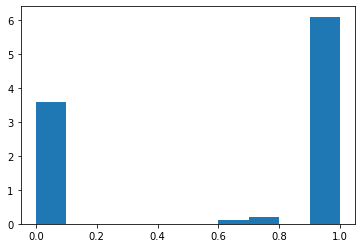

In [41]:
plt.hist(chivi_probs[1,:], bins=10, density=True, range=(0,1))
plt.show()

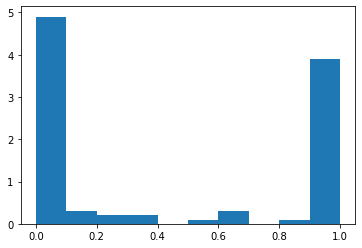

In [42]:
plt.hist(chivi_probs[10,:], bins=10, density=True, range=(0,1))
plt.show()

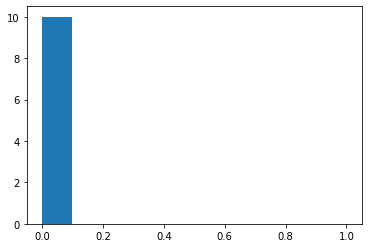

In [43]:
plt.hist(chivi_probs[D,:], bins=10, density=True, range=(0,1))
plt.show()

In [44]:
np.savetxt("chivi_probs.csv", chivi_probs, delimiter=",")

# Misc: testing other algorithms

## KLVI Non-mean field full-rank 

In [45]:
t_var_family = t_variational_family(D+1, 100)
full_klvi_objective_and_grad = black_box_klvi(t_var_family, stan_log_density, 100)

init_var_param = np.zeros(t_var_family.var_param_dim)

full_klvi_var_param, full_klvi_param_history, full_klvi_history, _ = \
    adagrad_optimize(n_iters, full_klvi_objective_and_grad, init_var_param, 
                     learning_rate=.1, learning_rate_end=.001)

Average Loss = 529.37: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 157.89it/s]


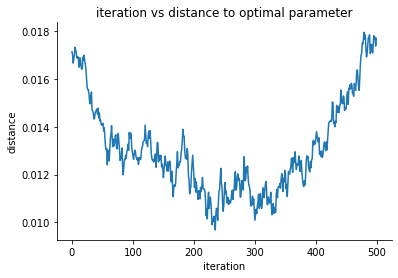

In [46]:
plot_dist_to_opt_param(full_klvi_param_history, full_klvi_var_param)

In [47]:
full_klvi_samples, full_klvi_slw, full_klvi_khat = \
    psis_correction(stan_log_density, t_var_family, full_klvi_var_param, mc_samples)

In [48]:
print(full_klvi_khat)

0.10758885550987357


In [49]:
full_klvi_slw

array([-11.18323412, -11.31687864, -11.46977969, ..., -11.53162536,
       -11.62182747, -11.61838622])

## KLVI Mean field with t distribution (df=40)

In [51]:
# mf_t_var_family = mean_field_t_variational_family(D+1, 40)
# klvi_objective_and_grad = black_box_klvi(mf_t_var_family, stan_log_density, 100)

# klvi_t_var_param, klvi_t_param_history, klvi_t_history, _ = \
#     adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

In [ ]:
#plot_dist_to_opt_param(klvi_t_param_history, klvi_t_var_param)

In [ ]:
#check_approx_accuracy(mf_t_var_family, klvi_t_var_param, true_mean, true_cov, verbose=True);

In [ ]:
#klvi_t_samples, klvi_t_slw, klvi_t_khat = \
#    psis_correction(stan_log_density, mf_t_var_family, klvi_t_var_param, mc_samples)

In [ ]:
#print(klvi_t_khat)

In [ ]:
#klvi_t_slw

## CHIVI Mean field with t distribution (df=40)

In [ ]:
mf_t_var_family = mean_field_t_variational_family(D+1, 40)
chivi_objective_and_grad = black_box_chivi(2, mf_t_var_family, stan_log_density, 400)

init_var_param = klvi_var_param.copy()
init_var_param[2:] += 3

chivi_t_var_param, chivi_t_param_history, chivi_t_history, _ = \
    adagrad_optimize(n_iters, chivi_objective_and_grad, init_var_param, learning_rate=.01)

In [ ]:
plot_dist_to_opt_param(chivi_t_param_history, chivi_t_var_param)

In [ ]:
chivi_t_samples, chivi_t_slw, chivi_t_khat = \
    psis_correction(stan_log_density, mf_t_var_family, chivi_t_var_param, mc_samples)

In [ ]:
print(chivi_t_khat)

In [ ]:
chivi_t_slw

### CHIVI full rank

In [46]:
# t_var_family = t_variational_family(D+1, 100)
# full_chivi_objective_and_grad = black_box_chivi(2, t_var_family, stan_log_density, 400)

# init_var_param = full_klvi_var_param.copy()
# init_var_param[2:] += 3

# full_chivi_var_param, full_chivi_param_history, full_chivi_history, _ = \
#     adagrad_optimize(n_iters, full_chivi_objective_and_grad, init_var_param, 
#                      learning_rate=.1, learning_rate_end=.001)

In [47]:
#plot_dist_to_opt_param(full_chivi_param_history, full_chivi_var_param)

In [48]:
#full_chivi_samples, full_chivi_slw, full_chivi_khat = \
#    psis_correction(stan_log_density, t_var_family, full_chivi_var_param, mc_samples)

In [49]:
#print(full_chivi_khat)

In [ ]:
#full_chivi_slw